# The Heath Gym Synthetic HIV Dataset Analysis

In [797]:
#We import the necessary libraries
import pandas as pd
import sys
#We set the path to the project folder
sys.path.append('/Users/mariehuynh/Desktop/PhD/Year 1/Fall Quarter/CS238/cs238_final_project/')
from src.preprocessing import * 
from src.environment import *
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [798]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### I. We look at the data and the different variables available.

In [799]:
df = pd.read_csv('data/ZZZ_C001_FakeHIV.csv', index_col=0)

In [800]:
df.head()

,VL,CD4,Rel CD4,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL (M),CD4 (M),Drug (M),PatientID,Timepoints
0,1141.895800,1070.03560,32.654160,1.0,4.0,0.0,3.0,1.0,5.0,0.0,1.0,1.0,0.0,0,0
1,134.190550,444.54190,14.775723,1.0,4.0,0.0,3.0,3.0,5.0,0.0,1.0,1.0,1.0,0,1
2,47.274055,230.53404,15.087534,1.0,4.0,0.0,3.0,3.0,5.0,0.0,0.0,0.0,1.0,0,2
3,120.055940,419.28403,26.615877,1.0,4.0,1.0,3.0,3.0,5.0,0.0,1.0,1.0,1.0,0,3
4,27.249084,230.72127,13.609289,1.0,4.0,1.0,3.0,3.0,5.0,0.0,1.0,1.0,1.0,0,4


In [801]:
print(f"There are {len(df['Base Drug Combo'].unique())} base drug combinations in the dataset.")

There are 6 base drug combinations in the dataset.


In [802]:
df['Base Drug Combo'].value_counts()

Base Drug Combo
0.0    394078
1.0     75339
3.0     29436
5.0     18560
4.0     12314
2.0      5233
Name: count, dtype: int64

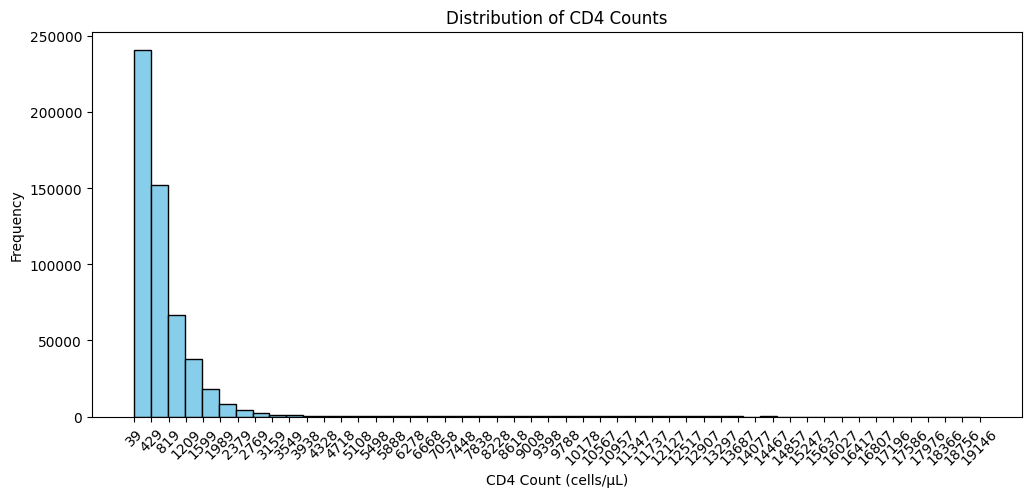

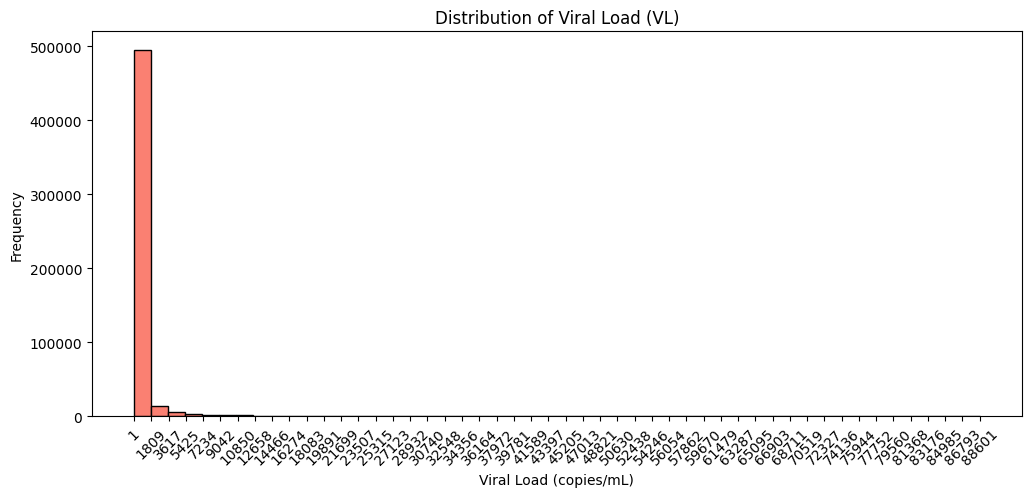

In [803]:
# Plotting the distribution of CD4 counts
plt.figure(figsize=(12, 5))
plt.hist(df['CD4'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of CD4 Counts')
plt.xlabel('CD4 Count (cells/µL)')
plt.ylabel('Frequency')
plt.xticks(np.linspace(df['CD4'].min(), df['CD4'].max(), 50), rotation=45)
plt.show()

# Plotting the distribution of Viral Load (VL)
plt.figure(figsize=(12, 5))
plt.hist(df['VL'], bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Viral Load (VL)')
plt.xlabel('Viral Load (copies/mL)')
plt.ylabel('Frequency')
plt.xticks(np.linspace(df['VL'].min(), df['VL'].max(), 50), rotation=45)
plt.show()


In [804]:
df = df[['VL', 'CD4', 'Base Drug Combo', 'Comp. INI', 'Comp. NNRTI', 'PatientID', 'Timepoints']]

In [805]:
df['PatientID'].nunique()

8916

In [806]:
#We group by PatientID and count the number of timepoints for each patient
timepoints_per_patient = df.groupby('PatientID')['Timepoints'].count()

timepoints_per_patient.describe()

count    8916.0
mean       60.0
std         0.0
min        60.0
25%        60.0
50%        60.0
75%        60.0
max        60.0
Name: Timepoints, dtype: float64

There are 8916 patients in our data with records of 60 months. 

In [807]:
#We want the summary statistics for the columns VL and CD4
df[['VL', 'CD4']].describe()

,VL,CD4
count,534960.000000,534960.000000
mean,905.857731,674.120672
std,4197.878019,729.376832
min,0.913153,39.063290
25%,16.507067,279.255997
50%,54.765035,465.809700
75%,209.027337,840.335037
max,88600.980000,19146.166000


### II. We preprocess the data and compute the rewards for the different transitions. 

In [808]:
#We bin the VL and CD4 columns
df = bin_vl_cd4_version1(df,target_sample=63000)
# Display the result
print(df[['VL', 'VL_binned', 'CD4', 'CD4_binned']])

CD4 Bin Counts:
  CD4_binned  Sample Count
0      0-201         66870
1    201-279         66870
2    279-360         66870
3    360-465         66871
4    465-607         66869
5    607-840         66870
6   840-1253         66870
7   1253-inf         66870

VL Bin Counts:
  VL_binned  Sample Count
0       0-9         66870
1      9-16         66870
2     16-30         66870
3     30-54         66870
4    54-100         66870
5   100-209         66870
6   209-724         66870
7   724-inf         66870
                 VL VL_binned         CD4 CD4_binned
0       1141.895800   724-inf  1070.03560   840-1253
1        134.190550   100-209   444.54190    360-465
2         47.274055     30-54   230.53404    201-279
3        120.055940   100-209   419.28403    360-465
4         27.249084     16-30   230.72127    201-279
...             ...       ...         ...        ...
534955    22.383543     16-30   815.18480    607-840
534956    43.911175     30-54  1441.06570   1253-inf
534957    23.0

/Users/mn/Desktop/Final_Project/cs238_final_project/src/preprocessing.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cd4_bin_counts = df.groupby(['CD4_binned']).size().reset_index(name='Sample Count')
/Users/mn/Desktop/Final_Project/cs238_final_project/src/preprocessing.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vl_bin_counts = df.groupby(['VL_binned']).size().reset_index(name='Sample Count')


In [809]:
df.head()

,VL,CD4,Base Drug Combo,Comp. INI,Comp. NNRTI,PatientID,Timepoints,CD4_binned,VL_binned
0,1141.895800,1070.03560,0.0,3.0,1.0,0,0,840-1253,724-inf
1,134.190550,444.54190,0.0,3.0,3.0,0,1,360-465,100-209
2,47.274055,230.53404,0.0,3.0,3.0,0,2,201-279,30-54
3,120.055940,419.28403,1.0,3.0,3.0,0,3,360-465,100-209
4,27.249084,230.72127,1.0,3.0,3.0,0,4,201-279,16-30


In [810]:
df = df.sort_values(by=['PatientID', 'Timepoints'])

In [811]:
max(df['Timepoints'])

59

In [812]:
total_samples = len(df)
target_sample=63000
num_bins_cd4 = total_samples // target_sample
num_bins_vl = total_samples // target_sample
print(num_bins_cd4)
cd4_bins = np.quantile(df['CD4'], np.linspace(0, 1, num_bins_cd4 + 1))
cd4_bins[0] = 0  # Set the smallest bin start to 0
cd4_bins[-1] = float('inf')  # Set the largest bin end to infinity

vl_bins = np.quantile(df['VL'], np.linspace(0, 1, num_bins_vl + 1))
vl_bins[0] = 0  # Set the smallest bin start to 0
vl_bins[-1] = float('inf')  # Set the largest bin end to infinity



8


In [813]:
num_bins_vl

8

In [814]:
score_range_cd4 = np.linspace(0.1, 1.0, len(cd4_bins) - 1)  
score_range_vl = np.linspace(-0.1, -1.0, len(vl_bins) - 1)  

cd4_bin_scores = {f"{int(cd4_bins[i])}-{int(cd4_bins[i+1]) if cd4_bins[i+1] != float('inf') else 'inf'}": score_range_cd4[i] 
                  for i in range(len(cd4_bins) - 1)}

# Generate scores for VL bins (lower VL gets higher scores, so reverse the range)
vl_bin_scores = {f"{int(vl_bins[i])}-{int(vl_bins[i+1]) if vl_bins[i+1] != float('inf') else 'inf'}": score_range_vl[i] 
                 for i in range(len(vl_bins) - 1)}

# Display the generated dictionaries
print("CD4 Bin Scores:", cd4_bin_scores)
print("VL Bin Scores:", vl_bin_scores)

CD4 Bin Scores: {'0-201': 0.1, '201-279': 0.2285714285714286, '279-360': 0.3571428571428572, '360-465': 0.48571428571428577, '465-607': 0.6142857142857143, '607-840': 0.7428571428571429, '840-1253': 0.8714285714285716, '1253-inf': 1.0}
VL Bin Scores: {'0-9': -0.1, '9-16': -0.2285714285714286, '16-30': -0.3571428571428572, '30-54': -0.48571428571428577, '54-100': -0.6142857142857143, '100-209': -0.7428571428571429, '209-724': -0.8714285714285716, '724-inf': -1.0}


In [815]:
df['CD4_Score'] = df['CD4_binned'].map(cd4_bin_scores).astype(float)
df['VL_Score'] = df['VL_binned'].map(vl_bin_scores).astype(float)
df.head()

,VL,CD4,Base Drug Combo,Comp. INI,Comp. NNRTI,PatientID,Timepoints,CD4_binned,VL_binned,CD4_Score,VL_Score
0,1141.895800,1070.03560,0.0,3.0,1.0,0,0,840-1253,724-inf,0.871429,-1.000000
1,134.190550,444.54190,0.0,3.0,3.0,0,1,360-465,100-209,0.485714,-0.742857
2,47.274055,230.53404,0.0,3.0,3.0,0,2,201-279,30-54,0.228571,-0.485714
3,120.055940,419.28403,1.0,3.0,3.0,0,3,360-465,100-209,0.485714,-0.742857
4,27.249084,230.72127,1.0,3.0,3.0,0,4,201-279,16-30,0.228571,-0.357143


In [816]:
transition_df = create_transitions(df)

Processed 0 patients...
Processed 100 patients...
Processed 200 patients...
Processed 300 patients...
Processed 400 patients...
Processed 500 patients...
Processed 600 patients...
Processed 700 patients...
Processed 800 patients...
Processed 900 patients...
Processed 1000 patients...
Processed 1100 patients...
Processed 1200 patients...
Processed 1300 patients...
Processed 1400 patients...
Processed 1500 patients...
Processed 1600 patients...
Processed 1700 patients...
Processed 1800 patients...
Processed 1900 patients...
Processed 2000 patients...
Processed 2100 patients...
Processed 2200 patients...
Processed 2300 patients...
Processed 2400 patients...
Processed 2500 patients...
Processed 2600 patients...
Processed 2700 patients...
Processed 2800 patients...
Processed 2900 patients...
Processed 3000 patients...
Processed 3100 patients...
Processed 3200 patients...
Processed 3300 patients...
Processed 3400 patients...
Processed 3500 patients...
Processed 3600 patients...
Processed 370

In [817]:
transition_df['s'].unique()

array([('840-1253', '724-inf'), ('360-465', '100-209'),
       ('201-279', '30-54'), ('201-279', '16-30'), ('1253-inf', '54-100'),
       ('465-607', '9-16'), ('360-465', '9-16'), ('279-360', '16-30'),
       ('279-360', '30-54'), ('1253-inf', '30-54'), ('0-201', '16-30'),
       ('607-840', '16-30'), ('279-360', '9-16'), ('1253-inf', '16-30'),
       ('840-1253', '16-30'), ('607-840', '30-54'), ('0-201', '9-16'),
       ('607-840', '9-16'), ('840-1253', '9-16'), ('360-465', '0-9'),
       ('201-279', '9-16'), ('201-279', '0-9'), ('360-465', '724-inf'),
       ('201-279', '209-724'), ('279-360', '724-inf'),
       ('840-1253', '209-724'), ('0-201', '724-inf'),
       ('1253-inf', '724-inf'), ('201-279', '724-inf'),
       ('1253-inf', '209-724'), ('465-607', '724-inf'),
       ('607-840', '724-inf'), ('840-1253', '100-209'),
       ('465-607', '209-724'), ('360-465', '209-724'),
       ('279-360', '209-724'), ('607-840', '100-209'),
       ('1253-inf', '100-209'), ('465-607', '54-100')

In [818]:
#We save the dataframe to a csv file
transition_df.to_csv('data/transition_matrix.csv', index=False)

### III. We categorize the states and split our data into train and test sets.

In [819]:
transition_df = pd.read_csv('data/transition_matrix.csv')

In [820]:
#We get unique states from both 's' and 'sp' columns
unique_states = pd.unique(transition_df[['s', 'sp']].values.ravel())
#We create a mapping of states to integers
state_to_int = {state: idx + 1 for idx, state in enumerate(unique_states)}
int_to_state = {idx + 1: state for idx, state in enumerate(unique_states)}

#We get unique actions from the 'a' column
unique_actions = pd.unique(transition_df['a'])
#We create a mapping of actions to integers
action_to_int = {action: idx + 1 for idx, action in enumerate(unique_actions)}
int_to_action = {idx + 1: action for idx, action in enumerate(unique_actions)}


#We save the mapping to a json file
with open('data/state_to_int.json', 'w') as f:
    json.dump(state_to_int, f)

with open('data/int_to_state.json', 'w') as f:
    json.dump(int_to_state, f)

with open('data/action_to_int.json', 'w') as f:
    json.dump(action_to_int, f)

with open('data/int_to_action.json', 'w') as f:
    json.dump(int_to_action, f)


#We apply the mapping to the 's' and 'sp' columns
transition_df['s'] = transition_df['s'].map(state_to_int)
transition_df['sp'] = transition_df['sp'].map(state_to_int)
#We apply the mapping to the 'a' column
transition_df['a'] = transition_df['a'].map(action_to_int)

transition_df.head()

,s,a,r,sp
0,1,1,-1.128571,2
1,2,2,-1.000000,3
2,3,2,-0.742857,2
3,2,3,-1.000000,4
4,4,3,-0.485714,3


In [821]:
num_states = transition_df['s'].nunique()
num_actions = transition_df['a'].nunique()
gamma = 0.9
print(f"Number of states: {num_states}")
print(f"Number of actions: {num_actions}")

Number of states: 64
Number of actions: 44


In [822]:
#We save the transition matrix with the states mapped to integers
transition_df.to_csv('data/transition_matrix_train_int.csv')